# Microsoft Capstone | Group Project | MBD April 2024

Group Members: Hugo A. Bojórquez Gallardo | Sofia Depoortere | Filippo Listanti | Fernando Moreno Borrego | Christopher Stephan

## Imports & Model Setup

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# Fix path for models
sys.path.append(os.path.abspath(os.path.join("..", "3 - Models")))

from ctr_model import (
    load_and_process_data,
    train_logistic,
    train_lgbm_with_grid,
    features,
    compute_ndcg,
    evaluate_at_k,
    get_user_entity_vector,
)

In [2]:
# Load data
interactions, le_cat, news = load_and_process_data(
    '../2 - Preprocessing/processed_behaviours_train.parquet',
    '../2 - Preprocessing/processed_news_train.parquet',
    n_rows_behaviors=10000  # limit as before
)

In [3]:
# Prepare data
X = interactions[features].fillna(0)
y = interactions['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [4]:
# Logistic Regression
model_logistic = train_logistic(X_train, y_train)

In [5]:
model_logistic.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

### Light GBM

In [6]:
# LightGBM + Grid Search
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 300],
    'min_child_samples': [20, 50]
}
# Training with grid search (model + cv results)
model_lgbm, grid_results = train_lgbm_with_grid(X_train, y_train, param_grid)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 8104, number of negative: 194069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 202173, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8104, number of negative: 194069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the trai

In [7]:
# Results summary
results_df = pd.DataFrame(grid_results)
results_df = results_df[['mean_test_score', 'param_num_leaves', 'param_max_depth',
                         'param_learning_rate', 'param_n_estimators', 'param_min_child_samples']
                       ].sort_values(by='mean_test_score', ascending=False)

print(tabulate(results_df.head(10).round(4), headers='keys', tablefmt='fancy_grid'))

╒════╤═══════════════════╤════════════════════╤═══════════════════╤═══════════════════════╤══════════════════════╤═══════════════════════════╕
│    │   mean_test_score │   param_num_leaves │   param_max_depth │   param_learning_rate │   param_n_estimators │   param_min_child_samples │
╞════╪═══════════════════╪════════════════════╪═══════════════════╪═══════════════════════╪══════════════════════╪═══════════════════════════╡
│ 30 │            0.7528 │                 31 │                10 │                  0.05 │                  300 │                        50 │
├────┼───────────────────┼────────────────────┼───────────────────┼───────────────────────┼──────────────────────┼───────────────────────────┤
│ 22 │            0.7527 │                 31 │                -1 │                  0.05 │                  300 │                        50 │
├────┼───────────────────┼────────────────────┼───────────────────┼───────────────────────┼──────────────────────┼───────────────────────────┤

In [8]:
# Best model
model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 12156, number of negative: 291104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 303260, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
               min_child_samples=50, n_estimators=300, n_jobs=-1,
               random_state=42)

## Evaluation

In [9]:
def evaluate_model(model, X_val, y_val, interactions):
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, (y_pred_proba >= 0.5).astype(int))
    recall = recall_score(y_val, (y_pred_proba >= 0.5).astype(int))
    map_score = average_precision_score(y_val, y_pred_proba)
    ndcg = compute_ndcg(interactions.iloc[X_val.index], y_pred_proba)
    p_at_5, r_at_5, ndcg_at_5 = evaluate_at_k(interactions.iloc[X_val.index], y_pred_proba, k=5)
    p_at_10, r_at_10, ndcg_at_10 = evaluate_at_k(interactions.iloc[X_val.index], y_pred_proba, k=10)

    results_df = pd.DataFrame([{
        "AUC": auc_score, "Precision": precision, "Recall": recall, "MAP": map_score, "nDCG": ndcg,
        "Precision@5": p_at_5, "Recall@5": r_at_5, "nDCG@5": ndcg_at_5,
        "Precision@10": p_at_10, "Recall@10": r_at_10, "nDCG@10": ndcg_at_10
    }]).round(4)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return results_df

### Logistic Regression


Logistic Regression Evaluation:


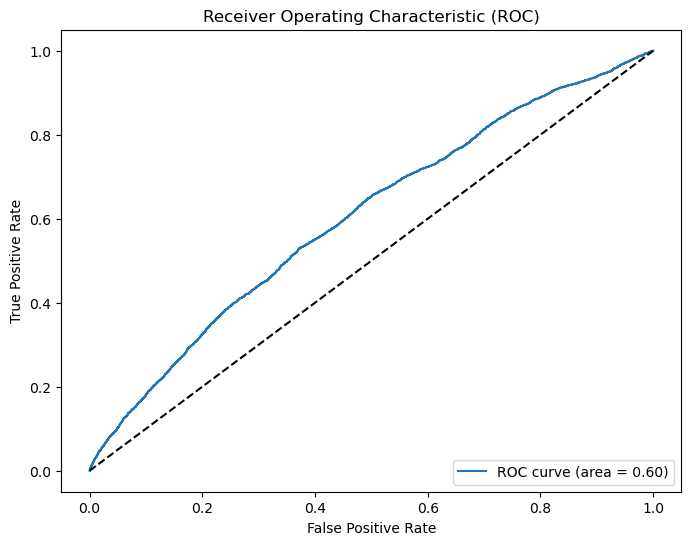

╒════╤════════╤═════════════╤══════════╤════════╤════════╤═══════════════╤════════════╤══════════╤════════════════╤═════════════╤═══════════╕
│    │    AUC │   Precision │   Recall │    MAP │   nDCG │   Precision@5 │   Recall@5 │   nDCG@5 │   Precision@10 │   Recall@10 │   nDCG@10 │
╞════╪════════╪═════════════╪══════════╪════════╪════════╪═══════════════╪════════════╪══════════╪════════════════╪═════════════╪═══════════╡
│  0 │ 0.6033 │      0.0531 │   0.5411 │ 0.0587 │ 0.5476 │        0.1453 │     0.6638 │   0.4976 │         0.0949 │      0.8433 │    0.5586 │
╘════╧════════╧═════════════╧══════════╧════════╧════════╧═══════════════╧════════════╧══════════╧════════════════╧═════════════╧═══════════╛


In [10]:
print("\nLogistic Regression Evaluation:")
results_logistic = evaluate_model(model_logistic, X_val, y_val, interactions)
print(tabulate(results_logistic, headers='keys', tablefmt='fancy_grid'))

### Light GBM


LightGBM Evaluation:


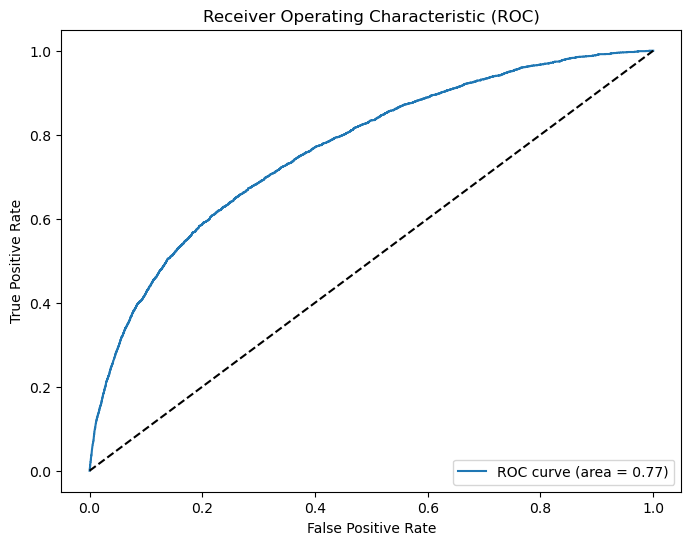

╒════╤════════╤═════════════╤══════════╤═══════╤════════╤═══════════════╤════════════╤══════════╤════════════════╤═════════════╤═══════════╕
│    │    AUC │   Precision │   Recall │   MAP │   nDCG │   Precision@5 │   Recall@5 │   nDCG@5 │   Precision@10 │   Recall@10 │   nDCG@10 │
╞════╪════════╪═════════════╪══════════╪═══════╪════════╪═══════════════╪════════════╪══════════╪════════════════╪═════════════╪═══════════╡
│  0 │ 0.7657 │      0.0927 │   0.6412 │ 0.148 │ 0.6437 │        0.1741 │     0.7788 │   0.6159 │         0.1033 │      0.9078 │    0.6605 │
╘════╧════════╧═════════════╧══════════╧═══════╧════════╧═══════════════╧════════════╧══════════╧════════════════╧═════════════╧═══════════╛


In [11]:
print("\nLightGBM Evaluation:")
results_lgbm = evaluate_model(model_lgbm, X_val, y_val, interactions)
print(tabulate(results_lgbm, headers='keys', tablefmt='fancy_grid'))

## User Specific Recommendation

In [12]:
# Safe cosine similarity between user and candidate entity vectors
def safe_cosine_similarity(user_vec, item_vec):
    if not isinstance(item_vec, np.ndarray) or not isinstance(user_vec, np.ndarray):
        return 0.0
    if np.linalg.norm(item_vec) == 0 or np.linalg.norm(user_vec) == 0:
        return 0.0
    return cosine_similarity([user_vec], [item_vec])[0][0]

# Return all categories (with repetitions) from user's history
def get_user_categories_full(history, news_dict):
    return [news_dict[nid]['category'] for nid in history.split(' ') if nid in news_dict]

# Top-N most common categories from user history
def get_user_top_categories(history, news_dict, top_n=3):
    categories = get_user_categories_full(history, news_dict)
    return [cat for cat, _ in Counter(categories).most_common(top_n)]

In [13]:
user_id = interactions['user_id'].iloc[0]
user_history = interactions.loc[interactions['user_id'] == user_id, 'history'].values[0]
news_dict = news.set_index('news_id')[['category', 'subcategory', 'entity_vector']].to_dict('index')

user_top_categories = get_user_top_categories(user_history, news_dict, top_n=2)
user_entity_vector = get_user_entity_vector(user_history, news_dict)

# Filter candidates
user_history_list = user_history.split(' ')
candidate_articles = news[~news['news_id'].isin(user_history_list)].copy()
candidate_articles = candidate_articles[candidate_articles['category'].isin(user_top_categories)]
print(f"Filtered candidate pool: {len(candidate_articles)} articles matching user's top categories")

# Feature engineering
candidate_articles['category_combined'] = candidate_articles['category'] + ' ' + candidate_articles['subcategory']
candidate_articles['category_combined_enc'] = le_cat.transform(candidate_articles['category_combined'].fillna('unknown'))
candidate_articles['category_match'] = candidate_articles['category'].apply(lambda x: int(x in user_top_categories))
candidate_articles['subcategory_match'] = candidate_articles['subcategory'].apply(lambda x: 0)
candidate_articles['entity_similarity'] = candidate_articles['entity_vector'].apply(
    lambda vec: safe_cosine_similarity(user_entity_vector, vec)
)

# Fill interaction features with dummy values
for col in ['hour', 'num_clicks', 'history_length', 'user_avg_clicks', 'recency']:
    candidate_articles[col] = 0

candidate_features = candidate_articles[features].fillna(0)

Filtered candidate pool: 30625 articles matching user's top categories


In [14]:
# Predict and recommend for both models
for model_name, model in [('Logistic Regression', model_logistic), ('LightGBM', model_lgbm)]:
    candidate_articles['predicted_click_prob'] = model.predict_proba(candidate_features)[:, 1]
    recommended_articles = candidate_articles.sort_values('predicted_click_prob', ascending=False).head(5000)
    
    print(f"\nTop 5000 recommended articles for user {user_id} using {model_name}:")
    print(recommended_articles[['news_id', 'category', 'subcategory', 'predicted_click_prob']].head(10))  # Show top 10 for brevity


Top 5000 recommended articles for user U403465 using Logistic Regression:
       news_id category   subcategory  predicted_click_prob
37337   N97406       tv       tv news              0.573449
53798   N11025       tv  tv celebrity              0.572694
91921   N15898       tv       tv news              0.572272
31194  N106854       tv  tv celebrity              0.572008
62756  N110663       tv     tv videos              0.571325
93140  N107229       tv       tv news              0.569884
7386    N95997       tv       tv news              0.569830
60993   N90306       tv       tv news              0.569651
44743   N27978       tv       tv news              0.569345
5721   N107733       tv       tv news              0.569345

Top 5000 recommended articles for user U403465 using LightGBM:
       news_id category   subcategory  predicted_click_prob
41693  N110982       tv  tv celebrity              0.836243
75132   N65783       tv  tv celebrity              0.835523
36265    N5454       